In [1]:
import numpy as np
import pandas as pd
from scipy.stats import ttest_ind, sem
import seaborn as sns
import matplotlib.pyplot as plt
from biom import load_table
from scipy.stats import ttest_rel, wilcoxon, ttest_ind, spearmanr, pearsonr
from skbio.stats.composition import multiplicative_replacement
%matplotlib inline

Let's create the second subfigure with the oral saliva experiment

In [2]:
#load metadata
metadata = pd.read_table('../data/oral_metadata.txt', 
                         index_col=0)
metadata = metadata.loc[metadata.treatment == 'raw']

#load oral samples
table = load_table('../data/oral-collapsed-table.biom').to_dataframe().T

metadata = metadata.rename(columns={'HostSuject': 'HostSubject'}) 
metadata = metadata.sort_values(by=['HostSubject', 'Timepoint#'])
metadata = metadata.loc[metadata['HostSubject'] != 'B']
metadata = metadata.loc[metadata['HostSubject'] != 'J']
metadata = metadata.loc[metadata['HostSubject'] != 'D']

table = table.reindex(index=metadata.index)

# multinomial ranks
beta = pd.read_csv('../results/oral-results/beta.csv', index_col=0)

taxonomy = pd.read_table('../data/taxonomy.tsv', index_col=0)

In [3]:
beta = pd.merge(beta, taxonomy, left_index=True, right_index=True)

In [4]:
from matplotlib.colors import rgb2hex
def plot_trajectory(ax, df, name, title='', left_title='', ypad=0, logscale=False):
    df = df.dropna(subset=['brushing_event'])
    subs = df['HostSubject'].value_counts().index
    for i, sub in enumerate(np.sort(subs)):
        subdf = df.loc[df['HostSubject'] == sub]
        subdf = subdf.sort_values(by='brushing_event').iloc[::-1]
        cols = sns.color_palette("husl", 10)
        x = np.arange(2)
        y = subdf.groupby('brushing_event').mean()[name][::-1]
        y = y - y[0]
        e = subdf.groupby('brushing_event').agg(sem)[name][::-1]
        ax.errorbar(x, y, yerr=e, c='k', label=sub, marker='o')
    ax.set_xticks([0, 1])            
    ax.set_xticklabels(y.index)
    
    if logscale:
        ax.set_yscale('log')
        
    ax.set_title(title, fontsize=14)
    ax.set_xlabel('')
    for x in ax.get_xticklabels():
        x.set_fontsize(12)
    
    ax.set_ylabel(left_title, fontsize=14, labelpad=ypad, rotation=0)

    for y in ax.get_yticklabels():
        y.set_fontsize(12)    
    #ax.legend()

In [5]:
flowcount = (metadata['flow cell 5min 1'] + metadata['flow cell 5min 2']) / 2
rmp_table = table.apply(lambda x: x * 100 / x.sum(), axis=1)
qmp_table = pd.DataFrame(table.values * flowcount.values.reshape(-1, 1),
                         index=table.index, columns=table.columns)

In [6]:
actinomyces = 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Actinomycetales;f__Actinomycetaceae;g__Actinomyces'
haemophilus = 'k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Pasteurellales;f__Pasteurellaceae;g__Haemophilus'

rmp_data = pd.DataFrame({
    'log(Actinomyces/Haemophilus)': np.log10(rmp_table[actinomyces]) - np.log10(rmp_table[haemophilus]),
    'Actinomyces': rmp_table[actinomyces],
    'Haemophilus': rmp_table[haemophilus],
    'brushing_event': metadata['brushing_event'],
    'HostSubject': metadata['HostSubject'],
    'Timepoint#': metadata['Timepoint#']    
})

qmp_data = pd.DataFrame({
    'log(Actinomyces/Haemophilus)': np.log10(qmp_table[actinomyces]) - np.log10(qmp_table[haemophilus]),
    'Actinomyces': qmp_table[actinomyces],
    'Haemophilus': qmp_table[haemophilus],   
    'brushing_event': metadata['brushing_event'],
    'HostSubject': metadata['HostSubject'],
    'Timepoint#': metadata['Timepoint#']    
})

/Users/mortonjt/miniconda3/envs/songbird/lib/python3.5/site-packages/scipy/stats/stats.py:245: RuntimeWarning: The input array could not be properly checked for nan values. nan values will be ignored.
  "values. nan values will be ignored.", RuntimeWarning)
/Users/mortonjt/miniconda3/envs/songbird/lib/python3.5/site-packages/numpy/core/_methods.py:140: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/Users/mortonjt/miniconda3/envs/songbird/lib/python3.5/site-packages/numpy/core/_methods.py:132: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


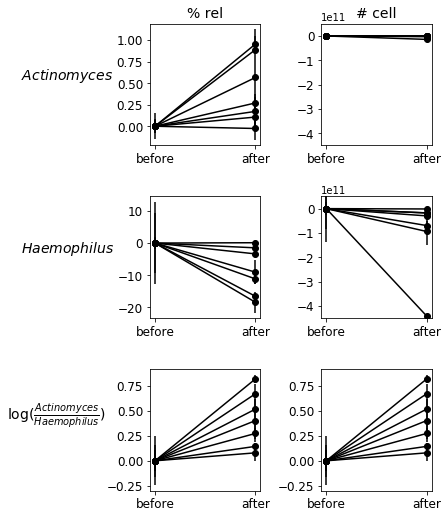

In [7]:
#fig, ax = plt.subplots()
#plot_trajectory(ax, rmp_data, name='balance')

num_taxa = 'Actinomyces'
denom_taxa = 'Haemophilus'

fig, axes = plt.subplots(3, 2, figsize=(6, 7))
plot_trajectory(axes[0][0], rmp_data, num_taxa, title='% rel',
                logscale=False, left_title=r"$\it{%s}$" % num_taxa, ypad=50)
plot_trajectory(axes[1][0], rmp_data, denom_taxa,
                logscale=False, left_title=r"$\it{%s}$" % denom_taxa, ypad=50)
plot_trajectory(axes[2][0], rmp_data, 'log(' + num_taxa + '/' + denom_taxa + ')', 
                left_title=r'$\log( \frac{' + num_taxa + '}{' + denom_taxa + '})$', ypad=50)

plot_trajectory(axes[0][1], qmp_data, num_taxa, title='# cell', logscale=False)
plot_trajectory(axes[1][1], qmp_data, denom_taxa, logscale=False)
plot_trajectory(axes[2][1], qmp_data, 'log(' + num_taxa + '/' + denom_taxa + ')')
axes[0][1].set_ylim([-4.5 * 1e11, 0.5*1e11])
axes[1][1].set_ylim([-4.5 * 1e11, 0.5*1e11])

plt.tight_layout(pad=0., w_pad=1., h_pad=2.)
plt.savefig('../figures/figure2/%s-%s.png' % (num_taxa, denom_taxa))

In [8]:
subrmp_data = rmp_data.dropna()
ttest_rel(subrmp_data.loc[subrmp_data['brushing_event'] == 'after', num_taxa],
          subrmp_data.loc[subrmp_data['brushing_event'] == 'before', num_taxa])

Ttest_relResult(statistic=2.892358785247117, pvalue=0.013516786816402742)

In [9]:
subrmp_data = rmp_data.dropna()
ttest_rel(subrmp_data.loc[subrmp_data['brushing_event'] == 'after', denom_taxa],
          subrmp_data.loc[subrmp_data['brushing_event'] == 'before', denom_taxa])

Ttest_relResult(statistic=-2.9155123383017822, pvalue=0.012947811517085486)

In [10]:
subqmp_data = qmp_data.dropna()
ttest_rel(subqmp_data.loc[subqmp_data['brushing_event'] == 'after', num_taxa],
          subqmp_data.loc[subqmp_data['brushing_event'] == 'before', num_taxa])

Ttest_relResult(statistic=-1.6102841216825878, pvalue=0.13331059975225512)

In [11]:
subqmp_data = qmp_data.dropna()
ttest_rel(subqmp_data.loc[subqmp_data['brushing_event'] == 'after', denom_taxa],
          subqmp_data.loc[subqmp_data['brushing_event'] == 'before', denom_taxa])

Ttest_relResult(statistic=-1.9990446446329533, pvalue=0.0687701743768079)

In [12]:
subrmp_data = rmp_data.dropna()
ttest_rel(subrmp_data.loc[subqmp_data['brushing_event'] == 'after', 
                          'log(' + num_taxa + '/' + denom_taxa + ')'],
          subrmp_data.loc[subqmp_data['brushing_event'] == 'before', 
                          'log(' + num_taxa + '/' + denom_taxa + ')'])

Ttest_relResult(statistic=4.0639430731587485, pvalue=0.001570563483981318)

In [13]:
subqmp_data = qmp_data.dropna()
ttest_rel(subqmp_data.loc[subqmp_data['brushing_event'] == 'after', 
                          'log(' + num_taxa + '/' + denom_taxa + ')'],
          subqmp_data.loc[subqmp_data['brushing_event'] == 'before', 
                          'log(' + num_taxa + '/' + denom_taxa + ')'])

Ttest_relResult(statistic=4.063943073158745, pvalue=0.0015705634839813284)

Second panel

In [14]:
metadata['brushing_event'].value_counts()

before    13
after     13
Name: brushing_event, dtype: int64

In [15]:
def paired_test_statistic(f, category, md, df):
    cats = list(md[category].value_counts().index)
    src = md[md[category] == cats[0]].index
    dest = md[md[category] == cats[1]].index
    return f(df.loc[src].values, df.loc[dest].values)[0]

def paired_test_pvalue(f, category, md, df):
    cats = list(md[category].value_counts().index)
    src = md[md[category] == cats[0]].index
    dest = md[md[category] == cats[1]].index
    return f(df.loc[src].values, df.loc[dest].values)[1]

In [16]:
#cell_coefs = pd.read_csv('../results/cell-norm-table.coefficients.csv', index_col=0)
#raw_coefs = pd.read_csv('../results/raw-table.coefficients.csv', index_col=0)
raw_beta = pd.read_csv('../results/oral-results/beta.csv', index_col=0)

In [17]:
#cell_beta = cell_coefs.loc['C(brushing_event)[T.before]'].sort_values()
#raw_beta = raw_coefs.loc['C(brushing_event)[T.before]', cell_beta.index]

In [18]:
#raw_table = load_table('../data/normalizations/raw-table.biom')
#cell_table = load_table('../data/normalizations/cell-norm-table.biom')
raw_table = load_table('../data/oral_deblurred.biom')
cell_table = load_table('../data/oral_deblurred.biom')

raw_df = pd.DataFrame(np.array(raw_table.matrix_data.todense()).T,
                      index=raw_table.ids(axis='sample'), 
                      columns=raw_table.ids(axis='observation'))
raw_df = raw_df.reindex(index=metadata.index, columns=raw_beta.index)

cell_df = pd.DataFrame(np.array(cell_table.matrix_data.todense()).T,
                       index=cell_table.ids(axis='sample'), 
                       columns=cell_table.ids(axis='observation'))
cell_df = cell_df.reindex(index=metadata.index, columns=raw_beta.index)
cell_df = cell_df.apply(lambda x: x * flowcount.loc[x.name], axis=1)

f = lambda x: paired_test_statistic(ttest_rel, category='brushing_event', md=metadata, df=x)
raw_tstats = raw_df.apply(f, axis=0)
cell_tstats = cell_df.apply(f, axis=0)

f = lambda x: paired_test_pvalue(ttest_rel, category='brushing_event', md=metadata, df=x)
raw_pvalues = raw_df.apply(f, axis=0)
cell_pvalues = cell_df.apply(f, axis=0)

Goal : plot every taxa that shows
    1. differences before and after brushing teeth
    2. differences between relative and absolute abundance

In [19]:
submetadata = metadata.dropna(subset=['brushing_event'])

subrmp_table = raw_df.loc[submetadata.index]
#subrmp_table['brushing event'] = submetadata['brushing event']
#subrmp_table['Timepoint#'] = submetadata['Timepoint#']
#subrmp_table['HostSubject'] = submetadata['HostSubject']

subqmp_table = cell_df.loc[submetadata.index]
#subqmp_table['brushing event'] = submetadata['brushing event']
#subqmp_table['Timepoint#'] = submetadata['Timepoint#']
#subqmp_table['HostSubject'] = submetadata['HostSubject']

In [20]:
#kname = actinomyces
kname = 'f58ef02fd3fe4f8f1c8ba13a3e205697'
def alr(x):
    return x / x.loc[kname]
alr_raw = raw_df.apply(alr, axis=1)
alr_cell = cell_df.apply(alr, axis=1)

In [21]:
f = lambda x: paired_test_statistic(ttest_rel, category='brushing_event', md=metadata, df=x)
alr_raw_tstats = alr_raw.apply(f, axis=0)
alr_cell_tstats = alr_cell.apply(f, axis=0)

f = lambda x: paired_test_pvalue(ttest_rel, category='brushing_event', md=metadata, df=x)
alr_raw_pvalues = alr_raw.apply(f, axis=0)
alr_cell_pvalues = alr_cell.apply(f, axis=0)

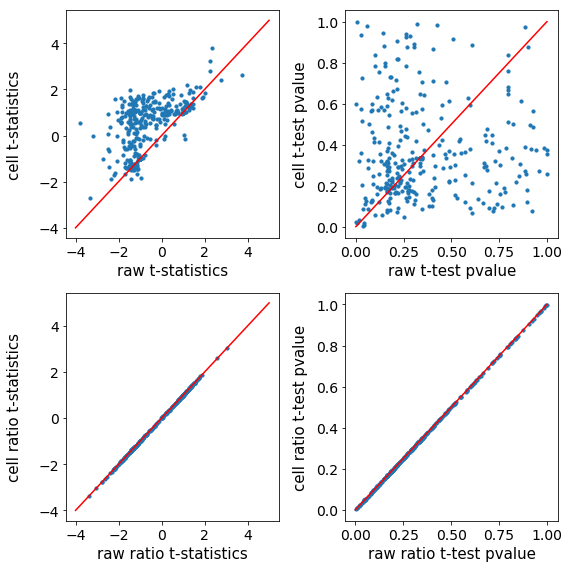

In [22]:
labelsize = 14
fontsize = 15
fig, ax = plt.subplots(2, 2, figsize=(8, 8))

ax[0][0].scatter(raw_tstats.loc[cell_tstats.index], cell_tstats, s=10)
ax[0][0].plot(np.arange(-4, 6), np.arange(-4, 6), '-r')
ax[0][0].set_xlabel('raw t-statistics', fontsize=fontsize) 
ax[0][0].set_ylabel('cell t-statistics', fontsize=fontsize, labelpad=16)
ax[0][0].xaxis.set_tick_params(labelsize=labelsize)
ax[0][0].yaxis.set_tick_params(labelsize=labelsize)

ax[0][1].scatter(raw_pvalues.loc[cell_pvalues.index], cell_pvalues, s=10)
ax[0][1].plot(np.linspace(0, 1), np.linspace(0, 1), '-r')
ax[0][1].set_xlabel('raw t-test pvalue', fontsize=fontsize) 
ax[0][1].set_ylabel('cell t-test pvalue', fontsize=fontsize, labelpad=8)
ax[0][1].xaxis.set_tick_params(labelsize=labelsize)
ax[0][1].yaxis.set_tick_params(labelsize=labelsize)

ax[1][0].scatter(alr_raw_tstats.loc[alr_cell_tstats.index], alr_cell_tstats, s=10)
ax[1][0].plot(np.arange(-4, 6), np.arange(-4, 6), '-r')
ax[1][0].set_xlabel('raw ratio t-statistics', fontsize=fontsize) 
ax[1][0].set_ylabel('cell ratio t-statistics', fontsize=fontsize, labelpad=16)
ax[1][0].xaxis.set_tick_params(labelsize=labelsize)
ax[1][0].yaxis.set_tick_params(labelsize=labelsize)

ax[1][1].scatter(alr_raw_pvalues.loc[alr_cell_pvalues.index], alr_cell_pvalues, s=10)
ax[1][1].plot(np.linspace(0, 1), np.linspace(0, 1), '-r')
ax[1][1].set_xlabel('raw ratio t-test pvalue', fontsize=fontsize) 
ax[1][1].set_ylabel('cell ratio t-test pvalue', fontsize=fontsize, labelpad=8)
ax[1][1].xaxis.set_tick_params(labelsize=labelsize)
ax[1][1].yaxis.set_tick_params(labelsize=labelsize)

plt.tight_layout()
plt.savefig('../figures/figure2/pvals-comparison.png')

In [23]:
kf = pd.DataFrame({'raw_stats': raw_tstats.loc[cell_tstats.index], 
                   'cell_stats': cell_tstats}).dropna()
spearmanr(kf.cell_stats, kf.raw_stats)

SpearmanrResult(correlation=0.5311096491171836, pvalue=2.1693690884617538e-28)

In [24]:
kf = pd.DataFrame({'raw_pvals': raw_pvalues.loc[cell_pvalues.index], 
                   'cell_pvals': cell_pvalues}).dropna()
spearmanr(kf.cell_pvals, kf.raw_pvals)

SpearmanrResult(correlation=0.09439619886983827, pvalue=0.06935183607188906)

In [25]:
kf = pd.DataFrame({'raw_stats': alr_raw_tstats.loc[alr_cell_tstats.index],
                   'cell_stats': alr_cell_tstats}).dropna()
spearmanr(kf.cell_stats, kf.raw_stats)

SpearmanrResult(correlation=1.0, pvalue=0.0)

In [26]:
kf = pd.DataFrame({'raw_pvals': alr_raw_pvalues.loc[alr_cell_pvalues.index], 
                   'cell_pvals': alr_cell_pvalues}).dropna()
spearmanr(kf.cell_pvals, kf.raw_pvals)

SpearmanrResult(correlation=1.0, pvalue=0.0)

In [27]:
#select_microbes = [actinomyces, haemophilus, prevotella, actinobacillus, porphyromonas, lautropia]
select_microbes = [actinomyces, haemophilus]
select_genera = list(map(lambda x: x.split(';')[-1], select_microbes))

In [28]:
taxa = pd.DataFrame(list(beta.Taxon.apply(lambda x: x.split(';')).values),
                    columns=['Kingdom', 'Phylum', 'Class', 'Order', 'Family', 'Genus', 'Species'],
                    index=beta.index)

In [29]:
taxa = taxa.fillna('None')

In [30]:
beta.head()

,Intercept,C(brushing_event)[T.before],Taxon,Confidence
99647b51f775c8ddde8ed36a7d60dbcd,6.004895,1.343743,k__Bacteria; p__Firmicutes; c__Bacilli; o__Lac...,0.999981
51121722488d0c3da1388d1b117cd239,6.484477,0.699402,k__Bacteria; p__Proteobacteria; c__Gammaproteo...,0.742617
d599ebe277afb0dfd4ad3c2176afc50e,5.303854,0.572709,k__Bacteria; p__Proteobacteria; c__Betaproteob...,0.796720
39c4199fe81f30a5b4b0fd5bf2f43c03,5.660547,0.237476,k__Bacteria; p__Firmicutes; c__Clostridia; o__...,0.996588
4629fbb5dde5f8ee07c2259d2887a8d4,5.292512,0.296501,k__Bacteria; p__Bacteroidetes; c__Bacteroidia;...,0.980117


In [31]:
stats = pd.DataFrame(
    {
        'raw_tstats': cell_tstats,
        'cell_tstats': cell_tstats,
        'raw_pvalues': raw_pvalues,
        'cell_pvalues': cell_pvalues,
        'multinomial_ranks': beta["C(brushing_event)[T.before]"],
        'taxonomy': taxonomy.Taxon
    }
) 
stats = stats.reindex(
    columns=['raw_tstats', 'cell_tstats', 'raw_pvalues', 
             'cell_pvalues', 'multinomial_ranks', 'taxonomy'])
stats.to_csv('../figures/Table_S1.csv') 

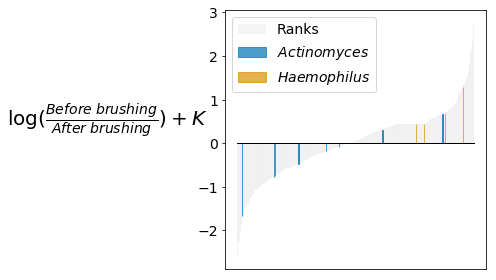

In [32]:
# plot all of the ranks
coefs = beta["C(brushing_event)[T.before]"].sort_values()
taxa = taxa.reindex(index=coefs.index)
genera = taxa.Genus.values
genera = np.array(list(map(lambda x: x.lstrip(), genera)))

x = np.arange(coefs.shape[0])
fig = plt.figure(figsize=(7, 4))
plt.bar(x, coefs, 1, label='Ranks', alpha=0.2, edgecolor='#D0D0D0', lw=0.1, color='#D0D0D0') #gray
plt.xlabel('species')
plt.xticks([])
plt.ylabel(r'$\log (\frac{Before \; brushing}{After \; brushing}) + K$', fontsize=20, labelpad=90, rotation=0)

genus_colors = dict(zip(select_genera, sns.color_palette("colorblind", len(select_genera))))

for genus in select_genera:
    
    filtered_beta = pd.Series(index=coefs.index).fillna(0)
    select_genus = genera == genus
    filtered_beta[select_genus] = coefs[select_genus]

    plt.bar(x, filtered_beta.values, 1, label="$\it{%s}$" % genus[3:], 
            alpha=0.7, edgecolor=genus_colors[genus], 
            facecolor=genus_colors[genus], lw=1)
plt.xlabel('')    
plt.tick_params(axis='both', which='major', labelsize=14)
plt.plot(x, np.array([0]*len(x)), c='k', lw=1)

plt.legend(fontsize=14)
plt.tight_layout()
fig.savefig('../figures/figure2/saliva-ranks.png')

In [33]:
metadata['flowcount'] = flowcount
submetadata = metadata[['brushing_event', 'flowcount']].dropna()
b = submetadata['brushing_event'] == 'before'
a = submetadata['brushing_event'] == 'after'
ttest_rel(submetadata.loc[b, 'flowcount'],
          submetadata.loc[a, 'flowcount'])

Ttest_relResult(statistic=2.0451076946684617, pvalue=0.06341691456648638)

In [34]:
pvals = pd.DataFrame(
    {
        'raw_pvals': raw_pvalues.loc[cell_pvalues.index], 
        'cell_pvals': cell_pvalues,
        'raw_tstats': raw_tstats.loc[cell_tstats.index], 
        'cell_tstats': cell_tstats,        
        'ranks': raw_beta['C(brushing_event)[T.before]']
    },
    index=cell_pvalues.index
)

In [35]:
pvals = pd.merge(pvals, taxonomy, left_index=True, right_index=True)

In [36]:
pvals.sort_values(by='cell_pvals').to_csv('../results/pval_deblurred_comparison.csv')